### Imports

In [183]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_float

from scipy import datasets
from scipy.fft import dctn, idctn
from skimage.color import rgb2ycbcr, ycbcr2rgb
from sklearn.metrics import mean_squared_error

### Utils

In [184]:
Q_jpeg = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 28, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float64)

def compress_ycbcr(image: np.ndarray, Q: np.ndarray) -> np.ndarray:
    block_size = 8
    
    image = rgb2ycbcr(image)
    compressed_image = np.zeros_like(image)
    
    for channel in range(3):
        rows, cols = image[:, :, channel].shape
        for i in range(0, rows, block_size):
            for j in range(0, cols, block_size):
                block = image[i : i+block_size, j : j+block_size, channel]
                dct_block = dctn(block)
                quantized_block = Q * np.round(dct_block / Q)
                compressed_image[i : i+block_size, j : j+block_size, channel] = idctn(quantized_block)

    return compressed_image

def show_images(images: list, titles: list, cmap=plt.cm.gray, file_name: str = None) -> None:
    num_images = len(images)

    if num_images != len(titles):
        raise ValueError("The number of images should match the number of titles.")

    num_cols = 3
    num_rows = np.ceil(num_images / num_cols).astype(int)

    plt.figure(figsize=(4 * num_cols, 4 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1).imshow(images[i], cmap=cmap)
        plt.title(titles[i])

    if file_name:
        plt.savefig(file_name)

    plt.tight_layout()
    plt.show()

### Sarcina 1
[6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

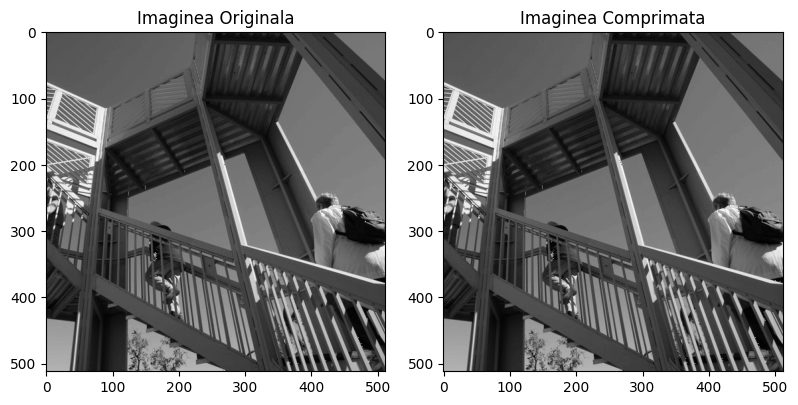

In [185]:
def compress_image(image: np.ndarray, Q_matrix: np.ndarray) -> np.ndarray:
    block_size = 8
    rows, cols = image.shape[:2]

    jpeg_image = np.zeros_like(image)
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i : i+block_size, j : j+block_size]
            dct_block = dctn(block)
            quantized_block = Q_matrix * np.round(dct_block / Q_matrix)
            jpeg_image[i : i+block_size, j : j+block_size] = idctn(quantized_block)

    return jpeg_image

image = datasets.ascent()
jpeg_image = compress_image(image, Q_jpeg)

show_images(images=[image, jpeg_image], titles=['Imaginea Originala', 'Imaginea Comprimata'])

### Sarcina 2
[4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

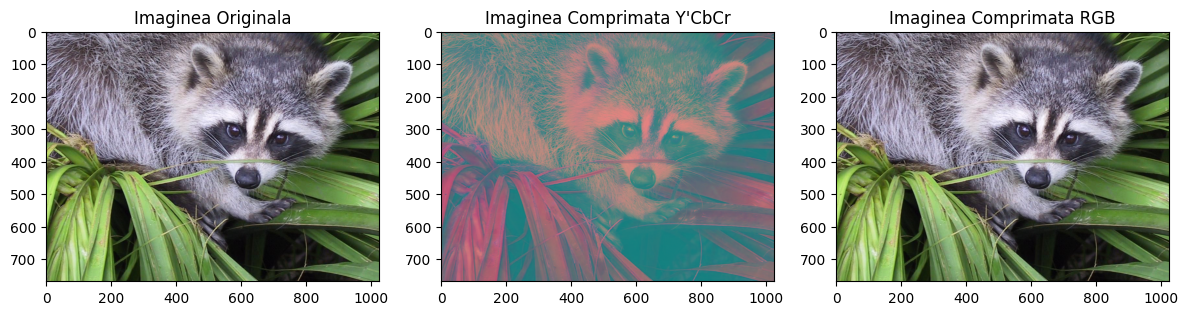

In [186]:
image_rgb = datasets.face()
image_ycbcr = rgb2ycbcr(image_rgb)
compressed_ycbcr = compress_ycbcr(image_rgb, Q_jpeg)

show_images(
    images=[image_rgb, np.clip(compressed_ycbcr, 0, 255).astype(np.uint8), np.clip(ycbcr2rgb(compressed_ycbcr), 0, 1)],
    titles=['Imaginea Originala', 'Imaginea Comprimata Y\'CbCr', 'Imaginea Comprimata RGB'],
    cmap=plt.cm.viridis
)

### Sarcina 3
[6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

MSE: 3.8978628248674916e-06
MSE: 0.0008662072358458694
MSE: 0.0018607418860999972
MSE: 0.002859127640389771
MSE: 0.0038638848720368695
MSE: 0.004892582916746135
MSE: 0.005490288416429484
MSE: 0.006349974564136776
MSE: 0.007724016176018551
MSE: 0.009915520461483605
MSE: 0.00926852052866069
MSE: 0.011056092433393453


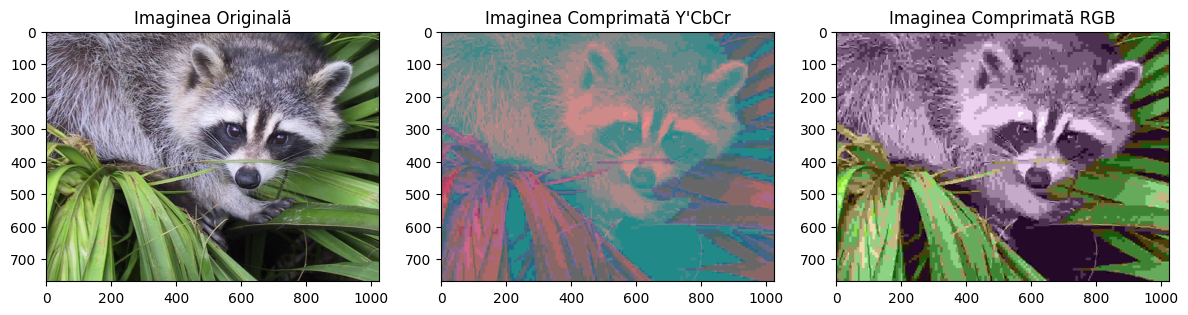

In [187]:
image_rgb = datasets.face()
image_ycbcr = rgb2ycbcr(image_rgb)

target_mse = 0.01
mse = 0
scale = 1
compressed_ycbcr = np.copy(image_rgb)

while mse < target_mse:
    Q_scaled = Q_jpeg * scale
    compressed_ycbcr = compress_ycbcr(image_rgb, Q_scaled)
    
    mse = mean_squared_error(img_as_float(image_rgb.flatten()), ycbcr2rgb(compressed_ycbcr).flatten())
    print(f"MSE: {mse}")
    
    scale += 50

show_images(
    images=[image_rgb, np.clip(compressed_ycbcr, 0, 255).astype(np.uint8), np.clip(ycbcr2rgb(compressed_ycbcr), 0, 1)],
    titles=['Imaginea Originală', 'Imaginea Comprimată Y\'CbCr', 'Imaginea Comprimată RGB'],
    cmap=plt.cm.viridis
)

### Sarcina 4
[4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

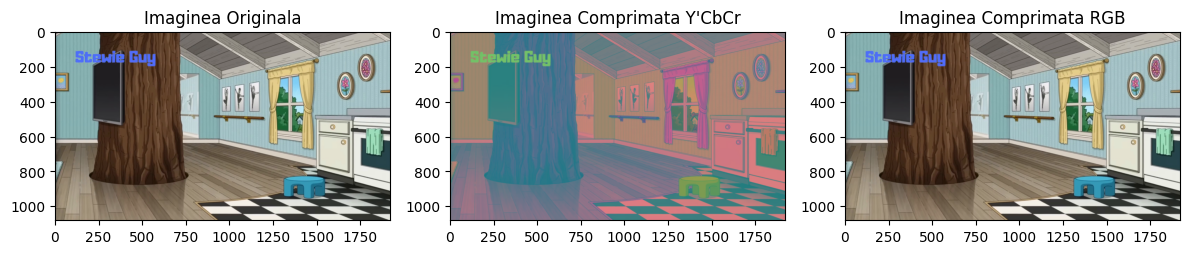

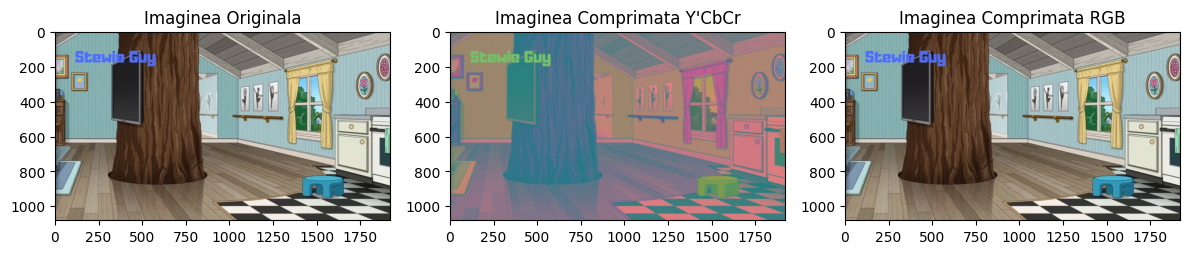

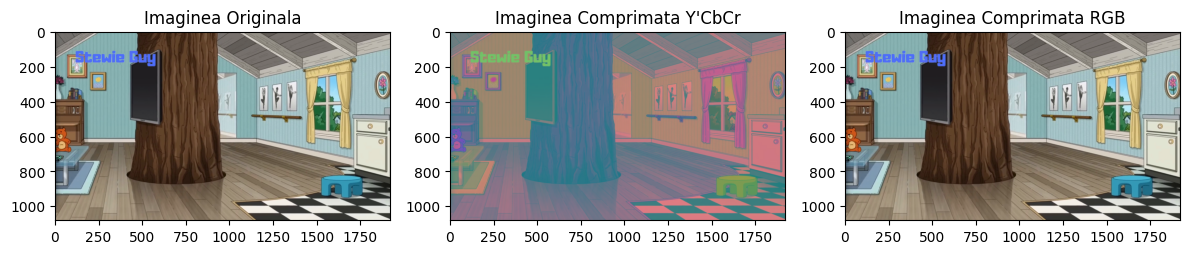

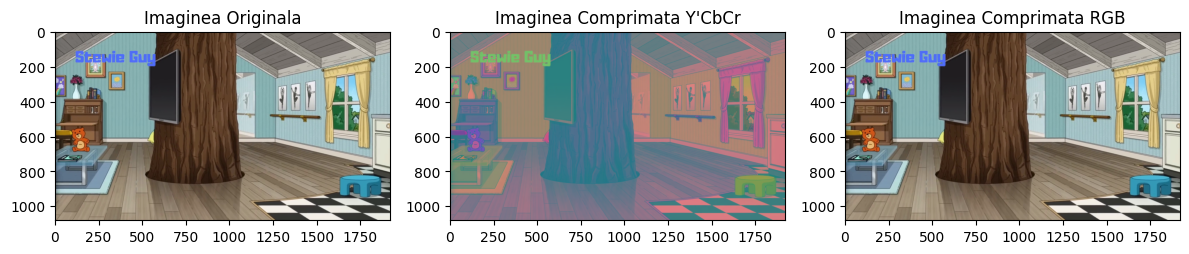

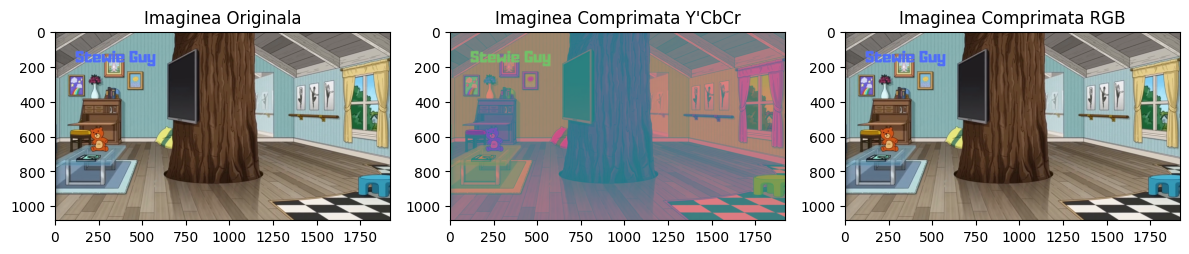

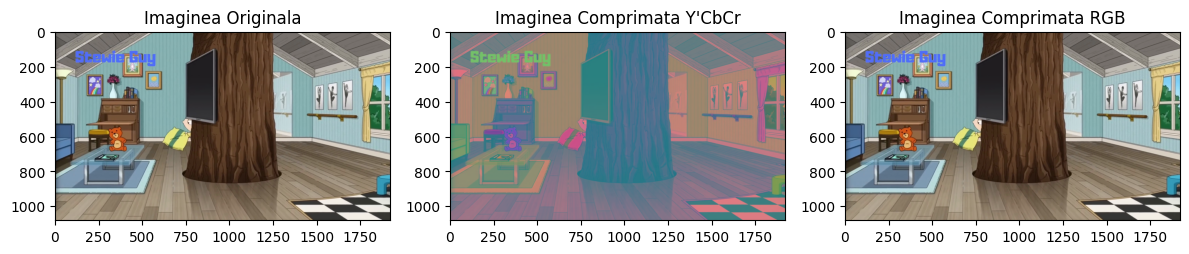

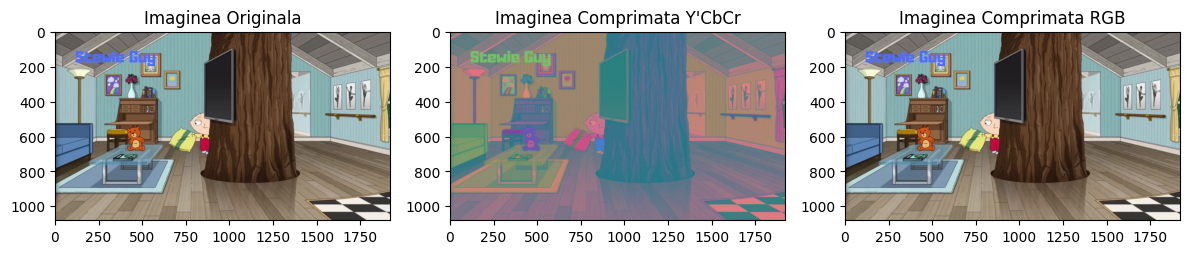

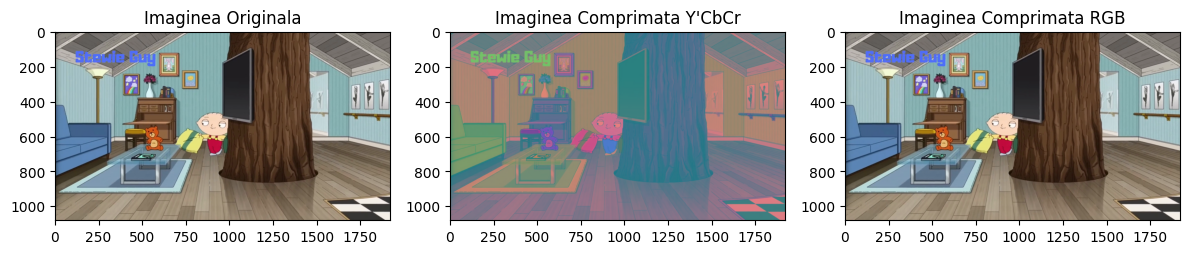

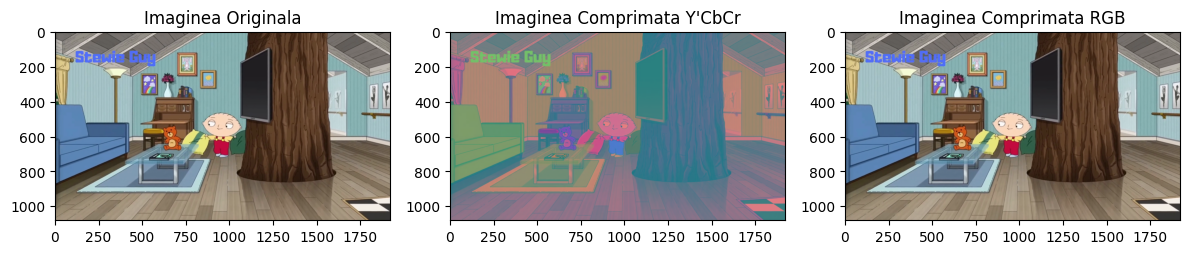

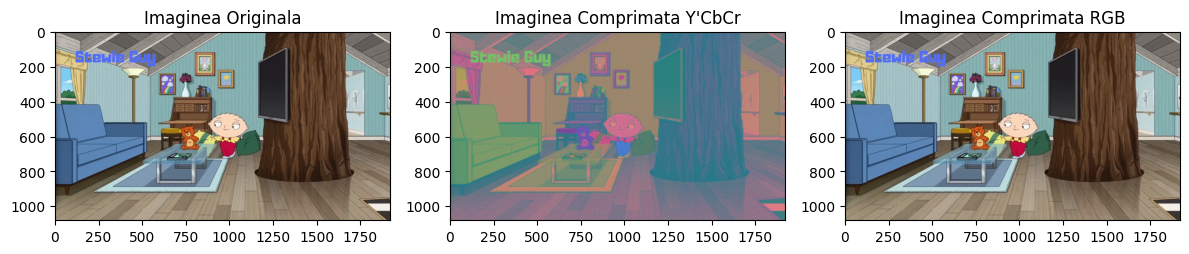

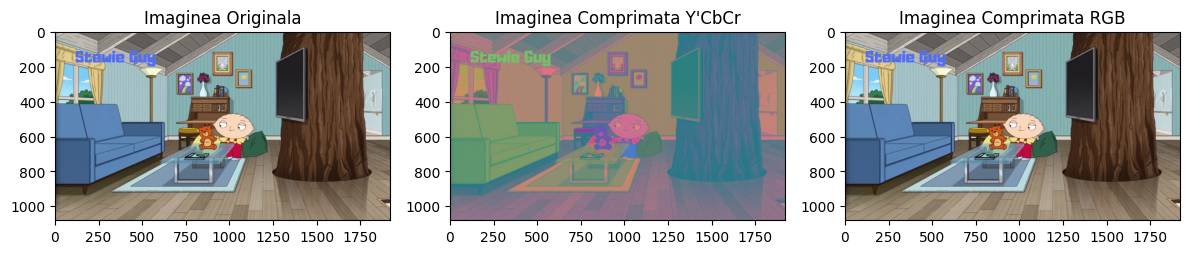

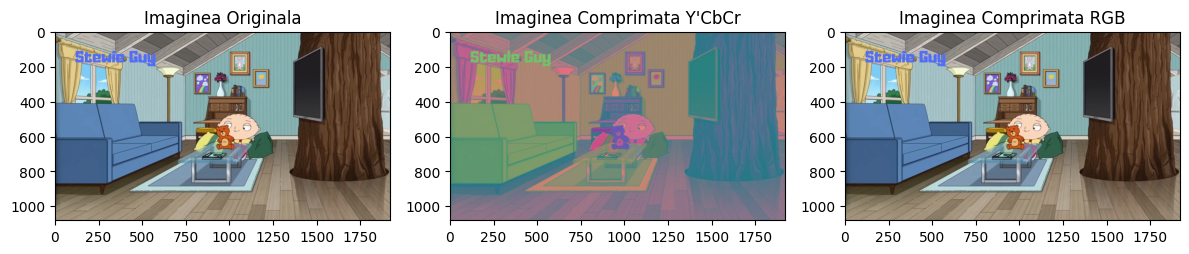

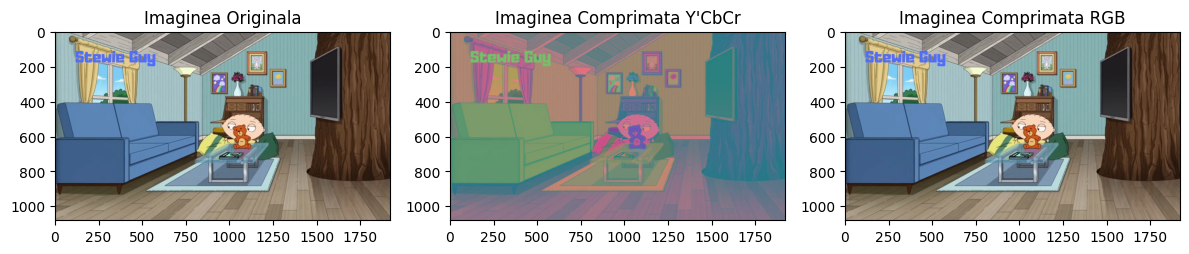

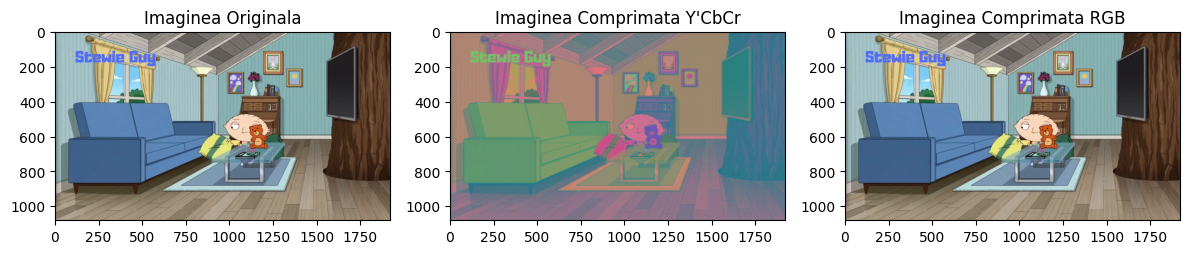

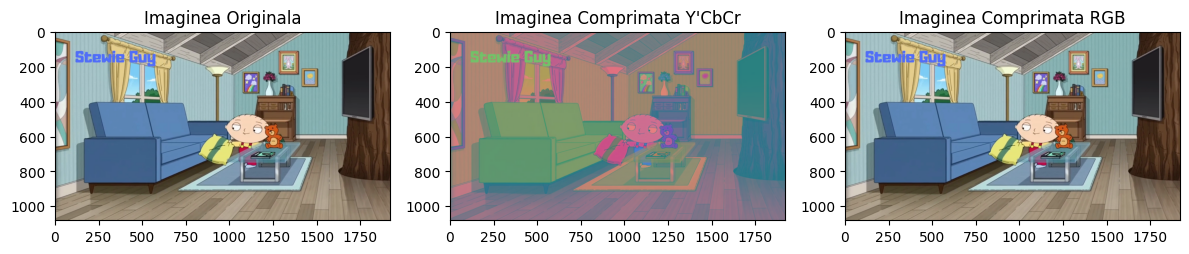

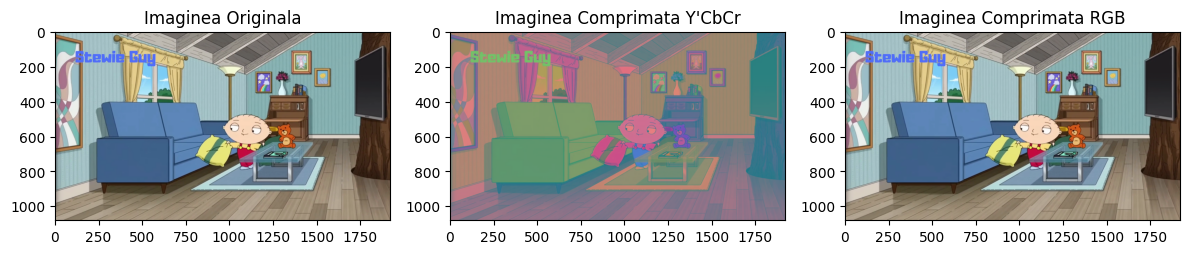

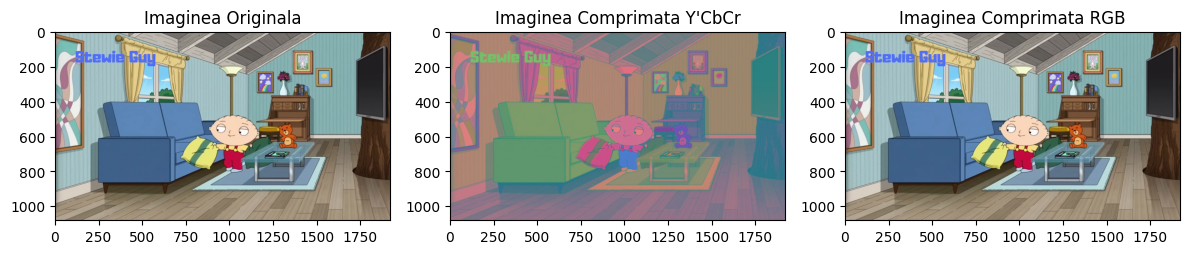

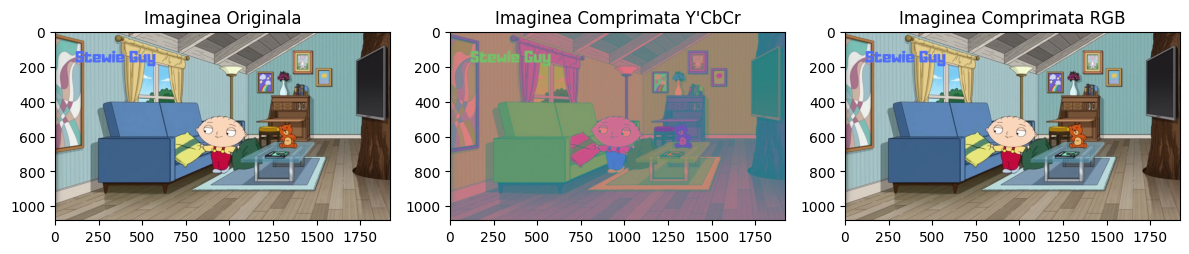

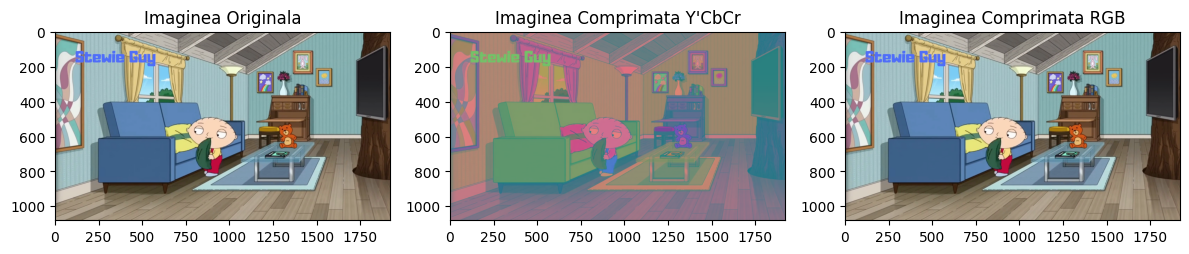

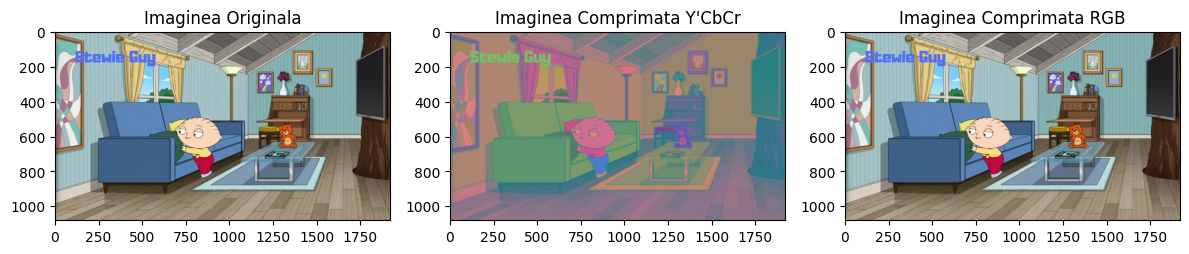

In [ ]:
video_path = 'orig.mp4'
reader = imageio.get_reader(video_path)

if not os.path.exists('frames'):
    os.mkdir('frames')

for contor, image_rgb in enumerate(reader):
    image_ycbcr = rgb2ycbcr(image_rgb)
    compressed_ycbcr = compress_ycbcr(image_rgb, Q_jpeg)
    
    if contor % 5 == 0:
        show_images(
            images=[image_rgb, np.clip(compressed_ycbcr, 0, 255).astype(np.uint8), np.clip(ycbcr2rgb(compressed_ycbcr), 0, 1)],
            titles=['Imaginea Originala', 'Imaginea Comprimata Y\'CbCr', 'Imaginea Comprimata RGB'],
            cmap=plt.cm.viridis
        )

reader.close()